**kaggle download**

In [1]:
#dowload dataset
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d felixzhao/productdemandforecasting

  0% 0.00/5.02M [00:00<?, ?B/s]
100% 5.02M/5.02M [00:00<00:00, 61.0MB/s]


In [2]:
!mkdir dataset3
!unzip productdemandforecasting.zip -d dataset3

Archive:  productdemandforecasting.zip
  inflating: dataset3/Historical Product Demand.csv  


**Import Libraries**

In [98]:
#Import Library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib import rcParams
from scipy.stats import norm, skew #statistics
from scipy import stats #qqplot
import statsmodels.api as sm #for decomposing the trends, seasonality

from statsmodels.tsa.statespace.sarimax import SARIMAX #Model

**Load Dataset**

In [200]:
df = pd.read_csv('/content/dataset3/Historical Product Demand.csv')
df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


In [201]:
print(df.shape)

(1048575, 5)


**Data Preparation**

In [202]:
df.dtypes

Product_Code        object
Warehouse           object
Product_Category    object
Date                object
Order_Demand        object
dtype: object

In [203]:
#convert date type from object to datetime
df['Date'] = pd.to_datetime(df['Date'], format = '%Y/%m/%d')

In [193]:
#Spliting date into year month day
# df['year'] = df['Date'].dt.year
# df['month'] = df['Date'].dt.month
# df['day'] = df['Date'].dt.day

In [204]:
#Finding null values

df.isnull().sum()

Product_Code            0
Warehouse               0
Product_Category        0
Date                11239
Order_Demand            0
dtype: int64

In [205]:
# drop the missing values because it is datetime we cannot impute missing values
df.dropna(inplace=True)

# check the null values again
df.isnull().sum()

Product_Code        0
Warehouse           0
Product_Category    0
Date                0
Order_Demand        0
dtype: int64

In [206]:
#Sort date
df.sort_values('Date', ignore_index=True, inplace=True)
df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0965,Whse_A,Category_006,2011-01-08,2
1,Product_1724,Whse_A,Category_003,2011-05-31,108
2,Product_1521,Whse_S,Category_019,2011-06-24,85000
3,Product_1521,Whse_S,Category_019,2011-06-24,7000
4,Product_1507,Whse_C,Category_019,2011-09-02,1250


In [207]:
#Order_demand convert into float

df['Order_Demand'] = df['Order_Demand'].str.replace("(","")
df['Order_Demand'] = df['Order_Demand'].str.replace(")","")
df['Order_Demand'] = df['Order_Demand'].astype('float')

<ipython-input-207-b8a05ed71fa4>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Order_Demand'] = df['Order_Demand'].str.replace("(","")
<ipython-input-207-b8a05ed71fa4>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Order_Demand'] = df['Order_Demand'].str.replace(")","")


**EDA**

In [208]:
#Select since 2012 to 2016
df = df[(df['Date']>='2012-01-01') & (df['Date']<='2016-12-31')].sort_values('Date', ascending=True)

In [209]:
print("Date start:", df["Date"].min(), "Date End", df["Date"].max())

Date start: 2012-01-01 00:00:00 Date End 2016-12-30 00:00:00


In [210]:
df['Order_Demand'].describe()

count    1.036643e+06
mean     4.944340e+03
std      2.902137e+04
min      0.000000e+00
25%      2.000000e+01
50%      3.000000e+02
75%      2.000000e+03
max      4.000000e+06
Name: Order_Demand, dtype: float64

In [211]:
#Skew Check
df['Order_Demand'].skew()

31.50608024269498

Text(0.5, 1.0, 'Warehouse')

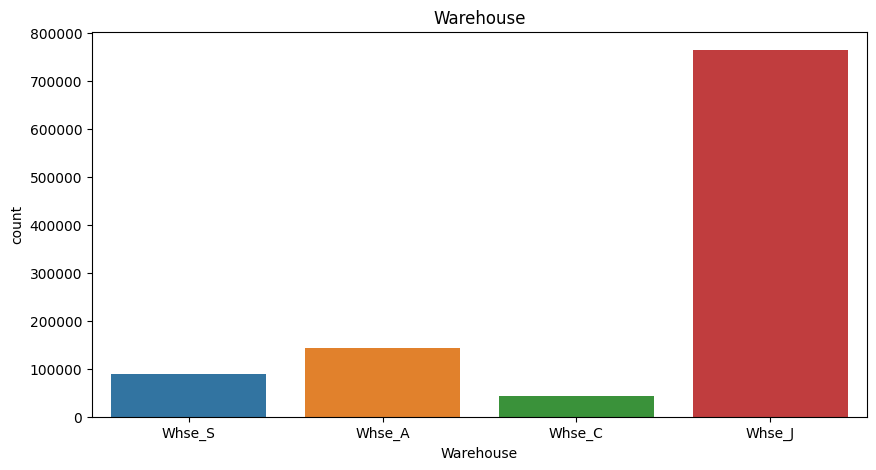

In [212]:
rcParams['figure.figsize'] = 10,5
sns.countplot(x=df['Warehouse'])
plt.title('Warehouse')

<ipython-input-213-bd19a781241e>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Order_Demand'],fit=norm)


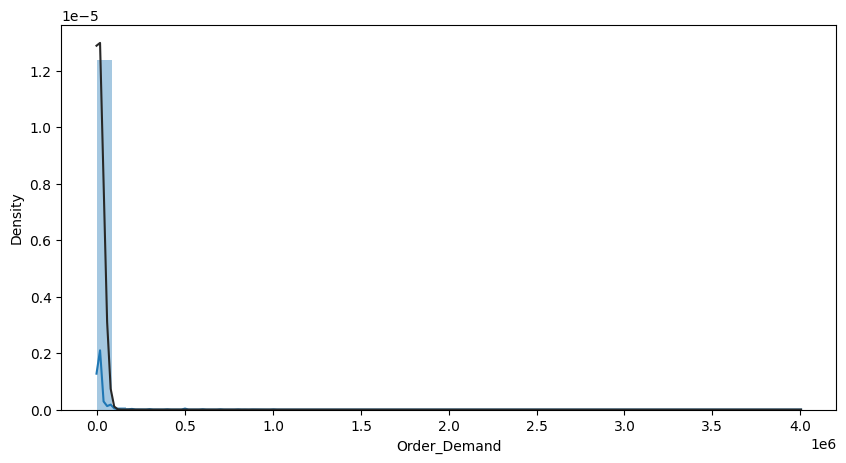

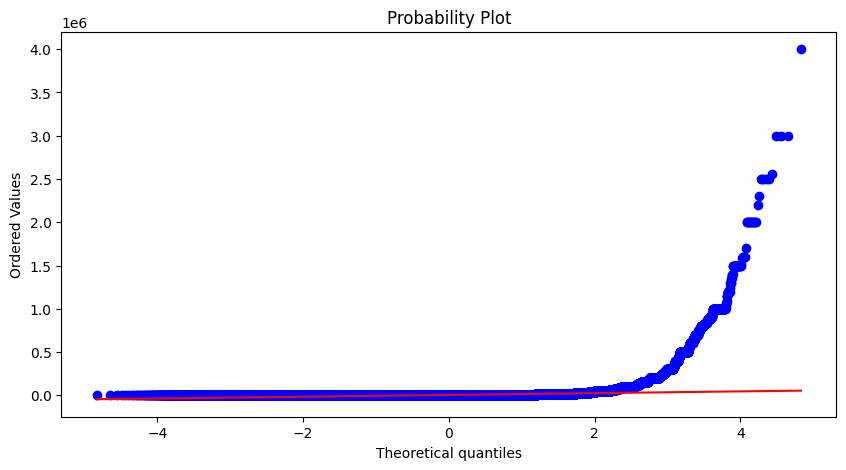

In [213]:
rcParams['figure.figsize'] = 10,5

sns.distplot(df['Order_Demand'],fit=norm)

#Get the QQ-plot
fig = plt.figure()
res = stats.probplot(df['Order_Demand'], plot=plt)
plt.show()

Text(0.5, 1.0, 'Product_Category')

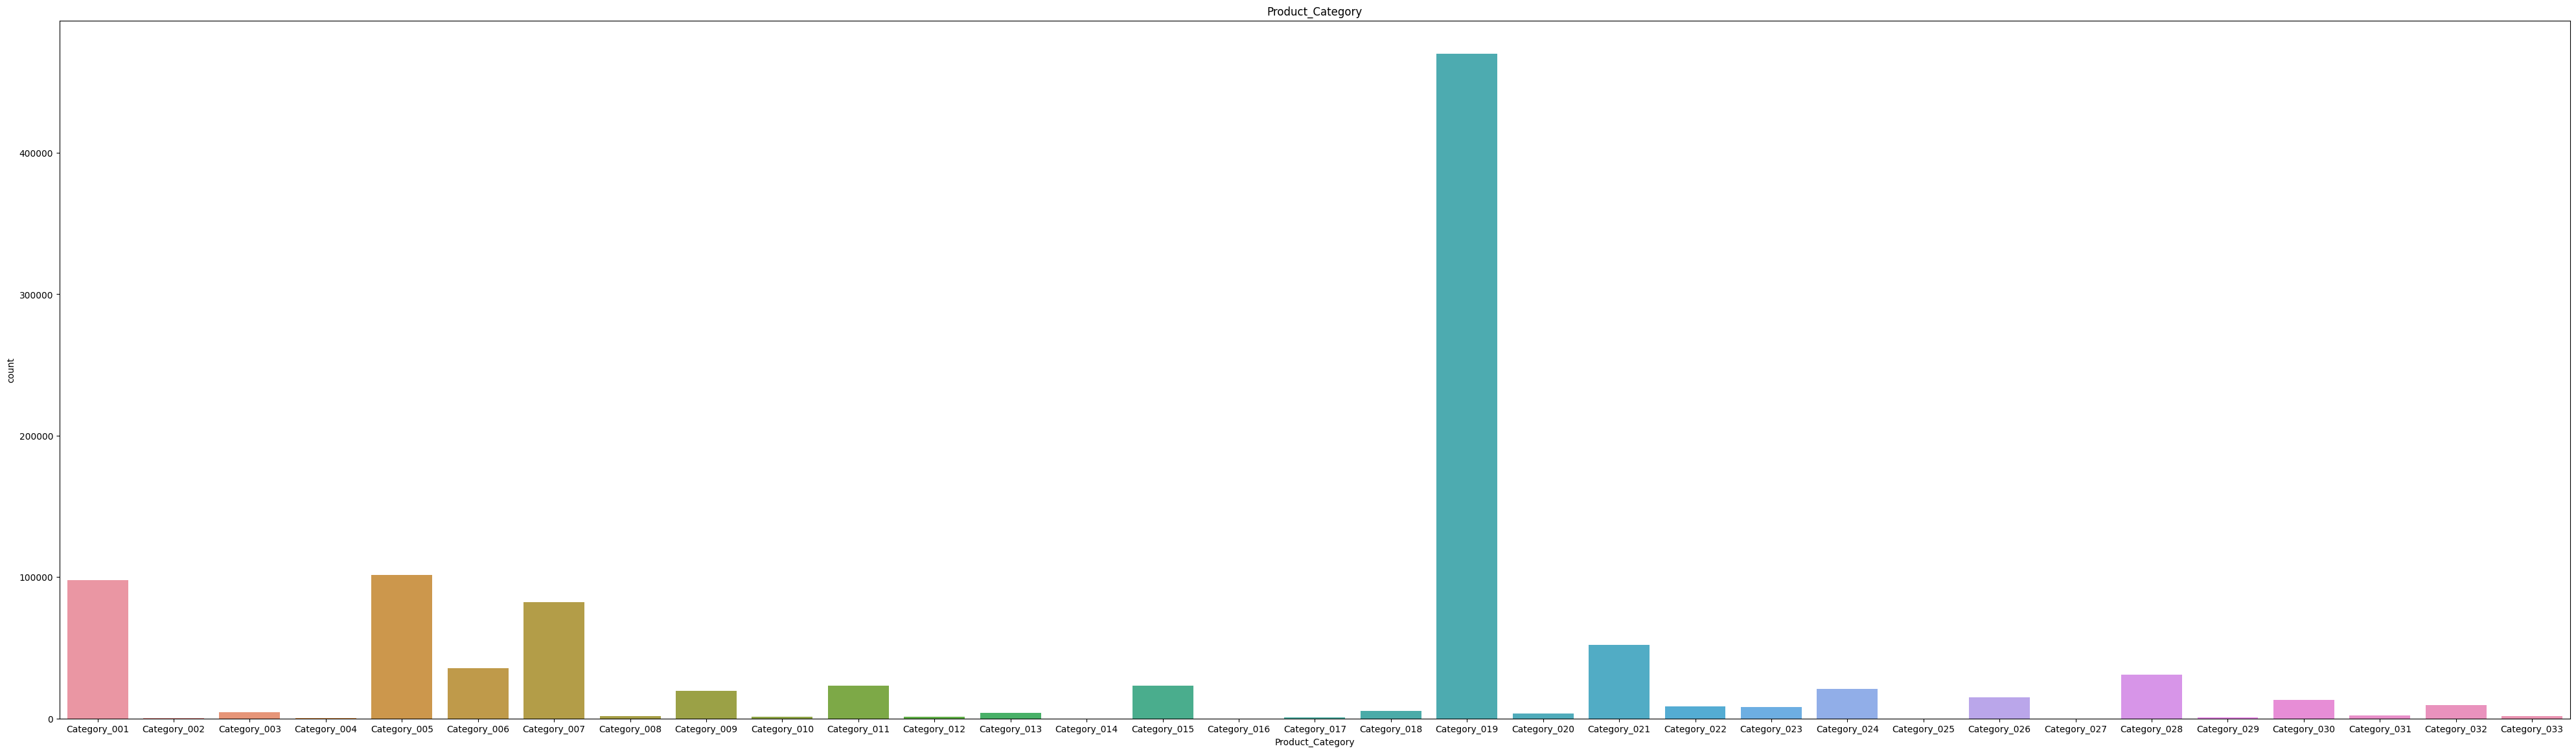

In [214]:
rcParams['figure.figsize'] = 50,14
sns.countplot(x=df['Product_Category'].sort_values(ascending = True))
plt.title('Product_Category')

<ipython-input-215-b4e9094fa95a>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('Warehouse').sum().sort_values('Order_Demand', ascending = False)


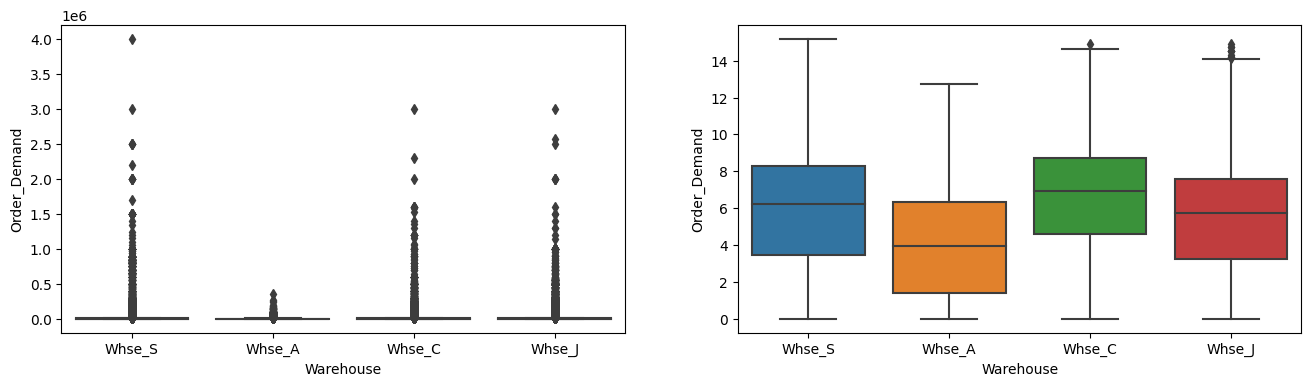

In [215]:
df.groupby('Warehouse').sum().sort_values('Order_Demand', ascending = False)
rcParams['figure.figsize'] = 16,4
f, axes = plt.subplots(1, 2)
#Regular Data
fig0 = sns.boxplot(x=df['Warehouse'],y=df['Order_Demand'], ax = axes[0])
#Data with Log Transformation
fig1 = sns.boxplot(x=df['Warehouse'],y=np.log1p(df['Order_Demand']),ax = axes[1])

del fig0, fig1

**Exploring Time Series**

In [157]:
df_ts = df.groupby('Date')['Order_Demand'].sum().reset_index()
df_ts = df_ts.set_index('Date')

In [158]:
df_ts.head()

,Order_Demand
Date,
2012-01-01,2.0
2012-01-02,680277.0
2012-01-03,1645257.0
2012-01-04,1295861.0
2012-01-05,8941774.0


In [159]:
df_ts.isnull().sum()

Order_Demand    0
dtype: int64

In [164]:
y = df_ts['Order_Demand'].resample('MS').mean()

In [132]:
#y = y.fillna(y.bfill())

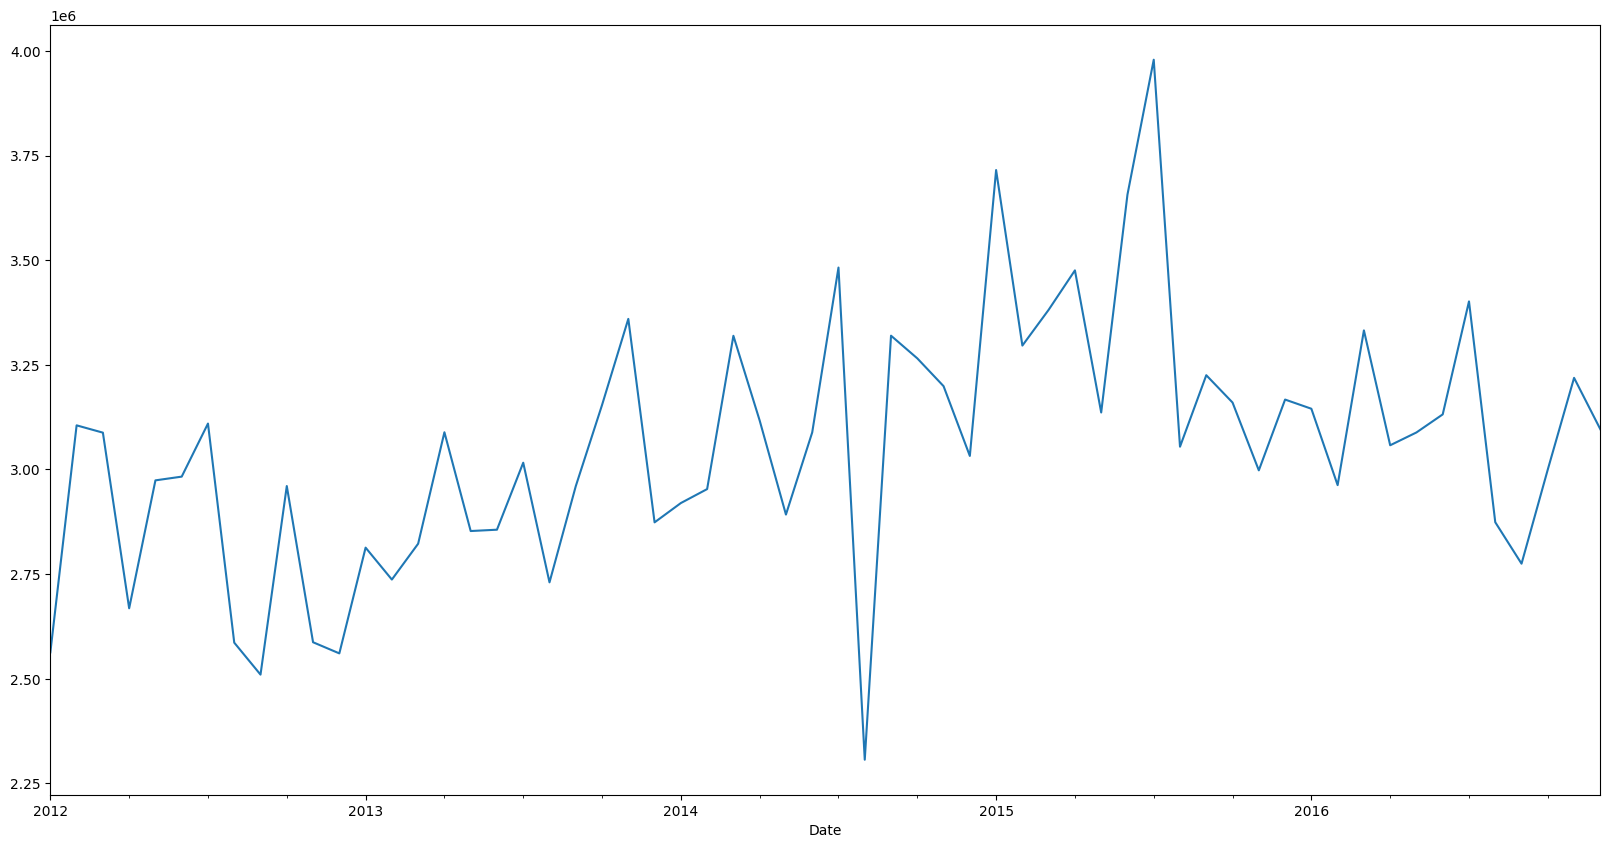

In [165]:
y.plot(figsize=(20,10))
plt.show()

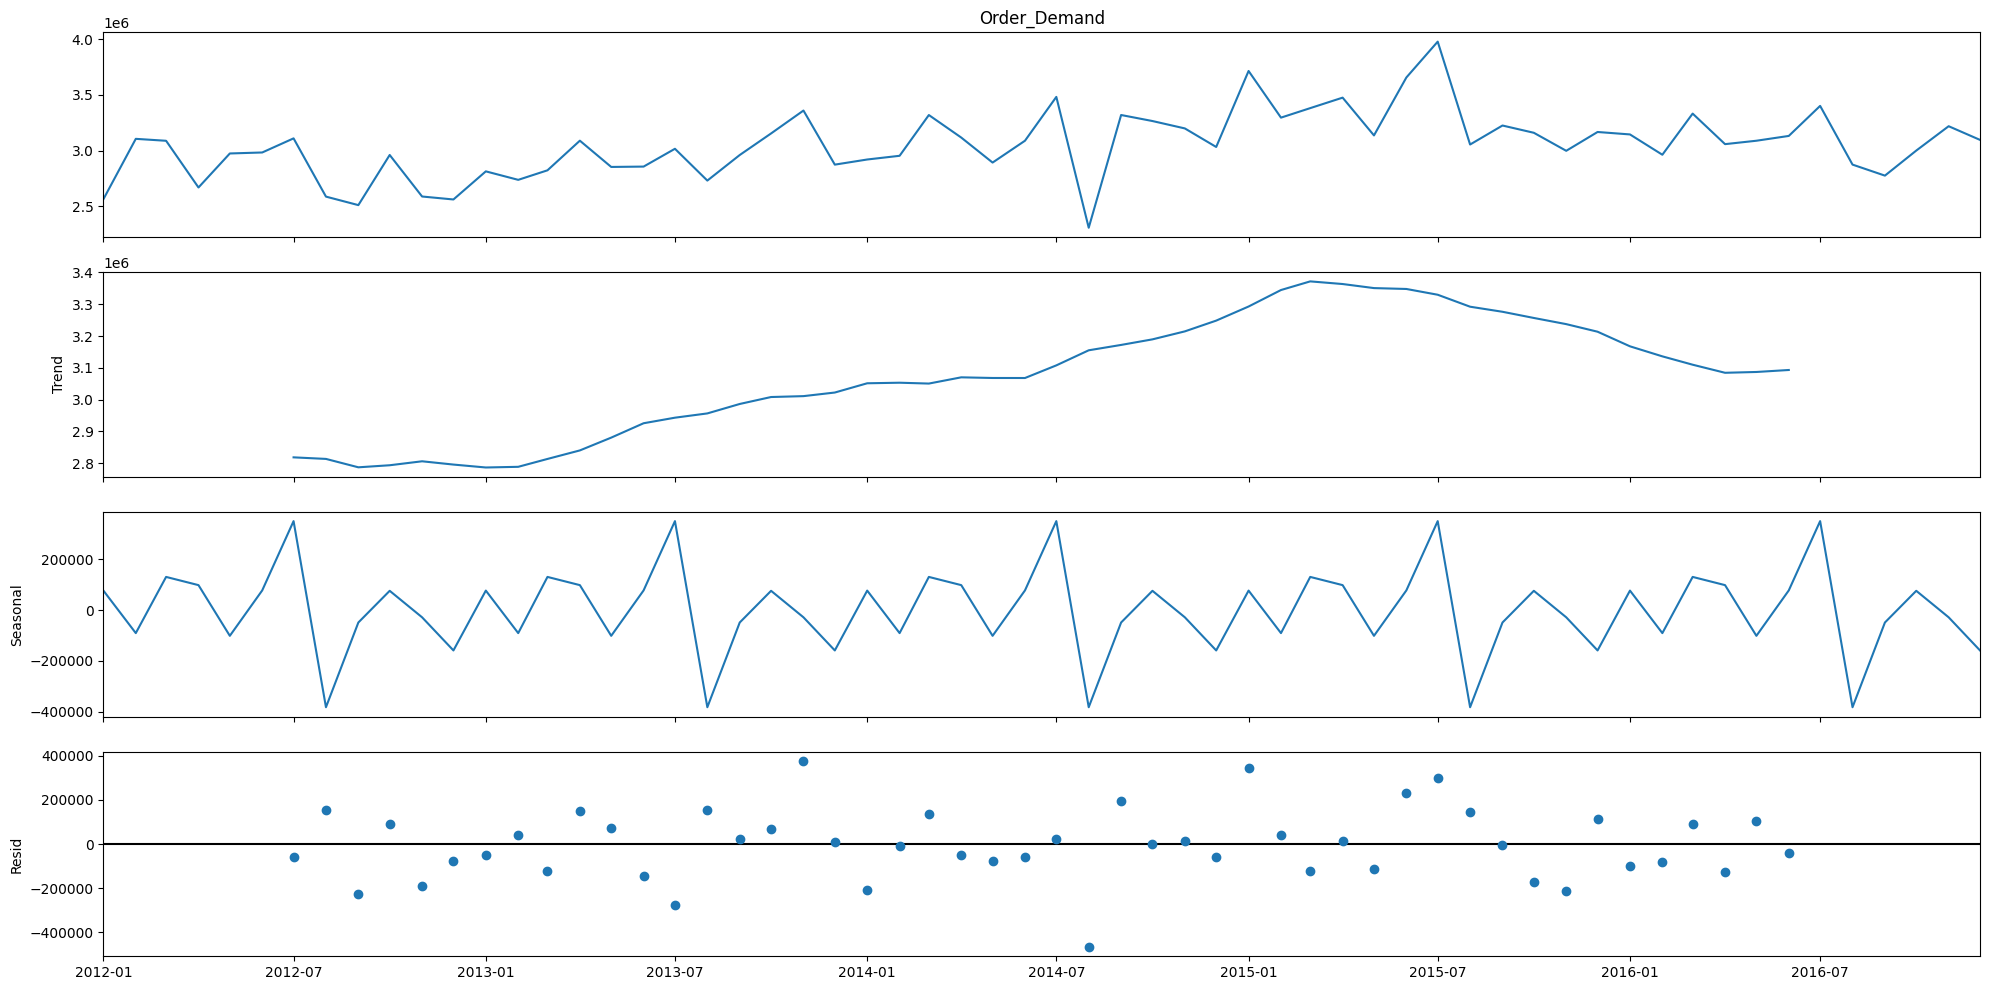

In [163]:
#Obesrve Trend and Seasonal

rcParams['figure.figsize'] = 20, 10
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

**ARIMA**

In [166]:
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
#print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX1: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX2: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX3: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX4: {} x {}'.format(pdq[2], seasonal_pdq[4]))

SARIMAX1: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX2: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX3: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX4: (0, 1, 0) x (1, 0, 0, 12)


In [167]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1932.23655778549
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1512.927583212436
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1338.8201294951011
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:3071.528024456278
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1366.5117513512635
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1340.8450308457734
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1023.6756022859483
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:3125.6813593306265
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1862.087487804522
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1471.1838032700705
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1305.3289813345489
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:2988.5628301644883
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1529.1005721650909
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1467.6395590277812
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1020.6347629759124
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:3070.4334214018813
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1648.7378898187837
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AI

In [170]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2450      0.368     -0.666      0.505      -0.966       0.476
ma.L1         -0.4385      0.325     -1.348      0.178      -1.076       0.199
ar.S.L12      -0.4568      0.208     -2.192      0.028      -0.865      -0.048
sigma2      1.018e+11   9.55e-13   1.06e+23      0.000    1.02e+11    1.02e+11


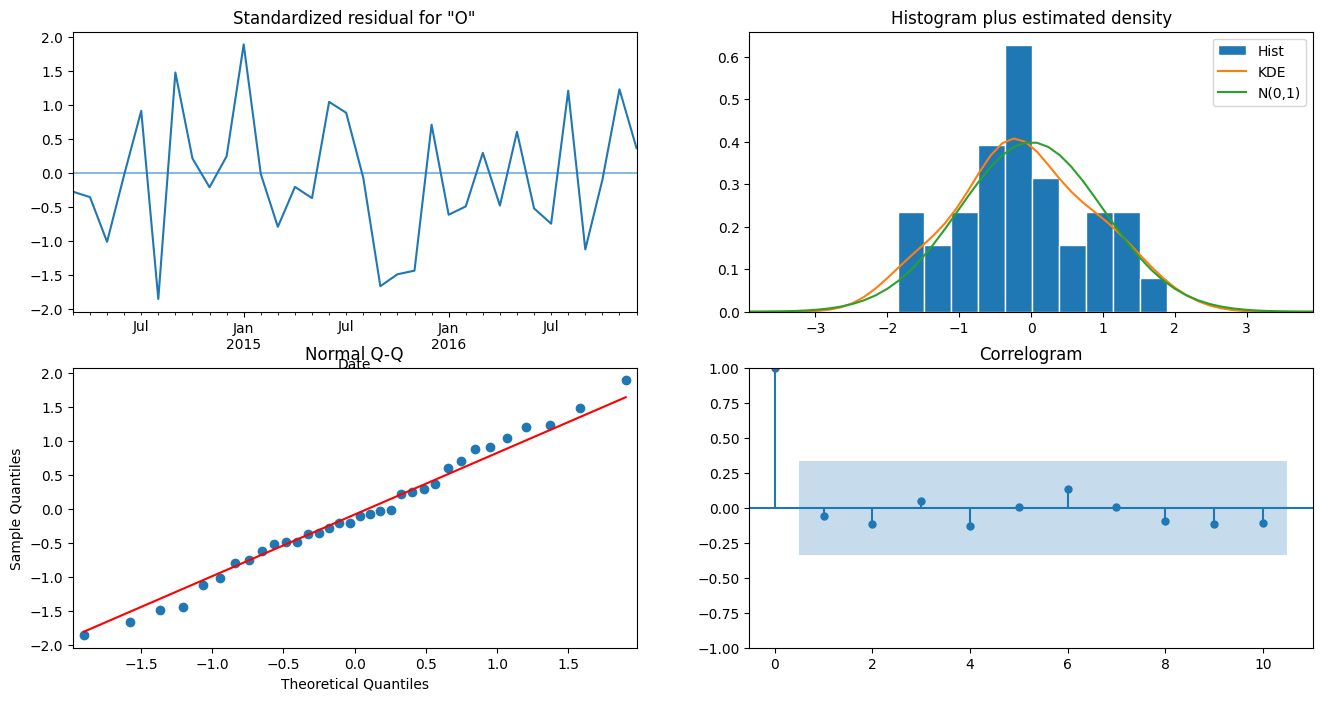

In [171]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()


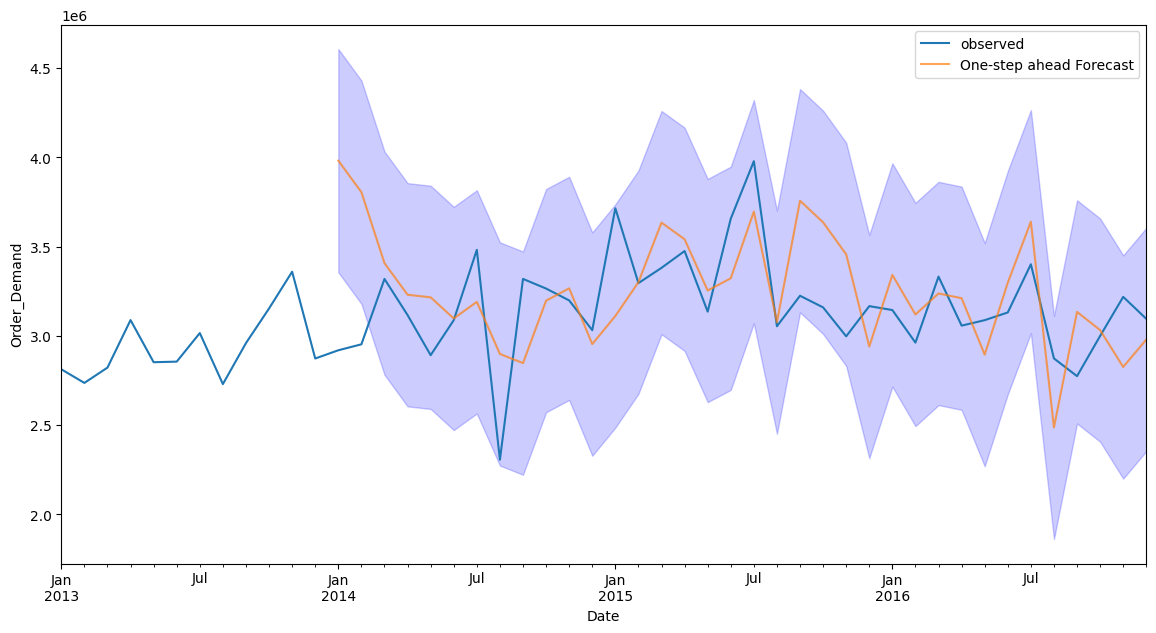

In [181]:
predictor = results.get_prediction(start=pd.to_datetime('2014-01-01'), dynamic=False)
pred_conf = predictor.conf_int()

#Plotting real and forecasted values
ax = y['2013':].plot(label='observed')
predictor.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='blue', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Order_Demand')
plt.legend()
plt.show()

In [178]:
y_pred = predictor.predicted_mean
y_true = y['2016-01-01':]
mse = ((y_pred - y_true) ** 2).mean()
print('MSE {}'.format(round(mse, 2)))
print('RMSE: {}'.format(round(np.sqrt(mse), 2)))

MSE 55459437815.96
RMSE: 235498.28


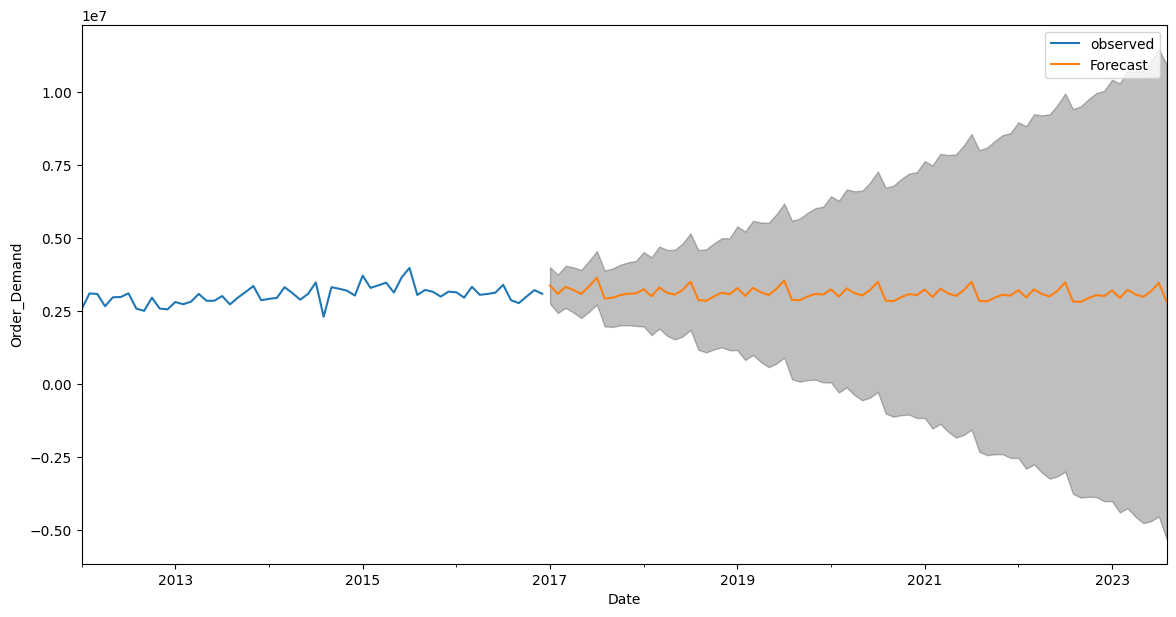

In [180]:
pred_uc = results.get_forecast(steps=80)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Order_Demand')
plt.legend()
plt.show()